#### to dos: 
- [x] pindah ke path yg bener dan semua files pengikutnya disesuaiin (LAUNCH gimana ya) 
- [ ] numpy yg penting cuman buat arg sort ga si (cuman di fungsi ambil bag berarti?)
- [ ] apus semua path file di folder d di awal launch - check
- [ ] coba pengganti ! (%?) buat di py biasa
- [ ] early stopping callback
- [ ] plot realtime progres eror di to do (berat)
- [x] masukin readme
- [ ] make the parameters vars customized (berat)
- [ ] semua yg panjang2 di main (termasuk 3 operator) jadi fungsi masing2 (class ga)
- [x] output tuned.yaml di akhir proses loop (baik setelah akhir generasi atau callback)

credits to the **YOLO v4 implementation of generic algorithm for hyperparameters tuning** that serves to assist the contributors in understanding the algorithm implementation -- and the few lines here and there taken directly and sometimes almost identically from their repo sure were much appreciated!

**Abel**, **Adam**, and **Gilbert**, who were much help; thank you.

In [1]:
import numpy as np
import pandas as pd
import rosbag
import os
import yaml
import random
import math as m
from scipy.spatial.distance import cdist
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib
import subprocess

from sklearn.metrics import mean_squared_error as mse, mean_absolute_error

ganti yaml tiap awal generasi

In [1]:
c="!!!!!asdasd"
"asdasdsa{c}"

'asdasdsa{c}'

In [2]:
#function for changing the parameter values (YAML file is used for the params to be called from the main UKF program)
def params_yaml(p,q,repo_path,temp=False):
    #read
    temp_yaml_dir = repo_path + '/config/temp.yaml'
    with open(temp_yaml_dir) as read_temp_yaml:             
        params = yaml.safe_load(read_temp_yaml)
    if q is not None:
        params['initial_estimate_covariance_P'] = p
        params['process_noise_covariance_Q'] = q

    #write and save
    if temp: #temp
        with open(temp_yaml_dir,'w') as write_temp_yaml:    
            yaml.safe_dump(params, write_temp_yaml, indent=2, allow_unicode=False) #dah berhasil ni     
    else: #best
        best_yaml_dir = repo_path + '/config/tuned.yaml'
        with open(best_yaml_dir,'w') as write_best_yaml:      
            yaml.safe_dump(params, write_best_yaml, indent=2, allow_unicode=False)
        print("Optimization is all done and the best params are now saved to {}".format(best_yaml_dir))

jalanin roslaunch berisi rosbag play, ukf dengan yaml baru untuk setiap generasi, dan rosbag record

In [3]:
# function for launching the 3 nodes: rosbag play back, the ukf algorithm, the recording of the rosbag to a temporary rosbag file that saves the estimation from the UKF
# the ntoebook (with !) and python (with %?) capability to run terminal command is VERY crucial in making this tuning possible in the ROS environment. It was the one thing that was going to be the make or break.
def launch(repo_path):
    launch_path = "{}/launch/launch_for_ga.launch".format(repo_path)
    !roslaunch {launch_path}
    
    # is not str WKWKWKWK gimana ya bair keren dipakein pwd nya.
    # eh kan kalo di cmd line mala lebih gampang buat ngerun file dari folder laen?

jalanin rosbag import cari rmse

In [4]:
def err(est, gt, t_est, t_gt):
    j = 1
    sample_est = []
    sample_gt = []
    for i in range(1, len(t_gt)):
        while (t_gt[i] > t_est[j]):
            j += 1
            
        sample_est.append(est[j])
        sample_gt.append(gt[i])
    rmse=sqrt(mse(sample_gt, sample_est))
    mae=mean_absolute_error(sample_gt, sample_est)
    print("rmse: "+str(rmse)+"\nmae: "+str(mae))
    return rmse,mae

#function for loading the estimation values recorded in the temporary bag file
def ambil_bag(repo_path):
    bag = rosbag.Bag(repo_path + '/bag/ga_temp.bag') #bagnya perlu udah ada ga ya? kayanya ngga, soalnya dibuatin dari launch filenya
    states_xy=[]
    states_xy_baru=[]
    t = []

    for topic, msg, time in bag.read_messages(topics=['/ukf_states']):
        states_xy.append([msg.x,msg.y])
        t.append(msg.stamp.to_sec())
    
    states_xy = np.array(states_xy)
    t = np.array(t)
    
    states_xy = states_xy[np.all(states_xy != 0,axis = 1)] #buang yg 0
    states_xy = states_xy[np.all(~np.isnan(states_xy),axis = 1)] #buang yg nan
    t = t[t != 0]

    utm=[]
    utm_baru=[]
    t_utm = []

    for topic, msg, time in bag.read_messages(topics=['/utm']):
        utm.append([msg.pose.pose.position.x,msg.pose.pose.position.y])
        t_utm.append(time.to_sec())

    utm = np.array(utm)
    t_utm = np.array(t_utm)
    min = utm[0]

    for i in range(len(states_xy)):
        pass
#         states_xy_baru.append([states_xy[i,0]-min[0],states_xy[i,1]-min[1]])
    states_xy_baru = states_xy - min #vectorization
    utm_baru = utm - min
#     states_xy_baru=np.array(states_xy_baru)
    
    for i in range(len(utm)):
        pass
#         utm_baru.append([utm[i,0]-min[0],utm[i,1]-min[1]])

    utm_baru=np.array(utm_baru)
    return states_xy_baru, utm_baru, t, t_utm

In [5]:
#function for plotting the estimation and the (unextended) GNSS points 
def plot(estimasi,gnss):
    plt.figure(figsize=(10,10))
    matplotlib.style.use('default')

    plt.scatter(estimasi[:,0],estimasi[:,1],s=2.,color='k') #odometry/filtered_map
    plt.scatter(gnss[:,0],gnss[:,1],s=5.,marker="x",c='C3',alpha=1)
    plt.show()

In [6]:
# function for saving the acquired parameter values to an external .txt file
# def catat(p,q,error,fitness,p_path,q_path,error_path,error_bygen_path,
#           fitness_path):
def catat(p,q,error,fitness,path):
    p = '%9.5g' * len(p) % tuple(p)
    q = '%9.5g' * len(q) % tuple(q)
    error = str(error)
    fitness = str(fitness)

    # adding new information to the temp files
    with open(path['p'], 'a') as h:  
        h.write(p + '\n')
    with open(path['q'], 'a') as h: 
        h.write(q + '\n')
    with open(path['error'], 'a') as h:  
        h.write(error + '\n')
    with open(path['error_bygen'], 'a') as h:  
        h.write(error + '\n')
    with open(path['fitness'], 'a') as h:  
        h.write(fitness + '\n')
        
    # loading the recently modified temp files nto numpy (for easier sort ith argsort)
    x_q=np.loadtxt(path['q'], ndmin=2)  
    x_p=np.loadtxt(path['p'], ndmin=2) 
    x_error=np.loadtxt(path['error'], ndmin=2)
    x_fitness=np.loadtxt(path['fitness'], ndmin=2)
    x_fitness_f=x_fitness.flatten()
    
    # saving and sorting by its corresponding fitness value
    np.savetxt(path['p'], x_p[np.argsort(-x_fitness_f)], '%9.5g')
    np.savetxt(path['q'], x_q[np.argsort(-x_fitness_f)], '%9.5g')
    np.savetxt(path['error'], x_error[np.argsort(-x_fitness_f)], '%9.5g')
    np.savetxt(path['fitness'], x_fitness[np.argsort(-x_fitness_f)], '%9.5g')  #[np.argsortnya ini nambah dimensi]

In [7]:
# delete all files in the path directory before launching
def clear_path(folder):
    os_folder = os.listdir(folder)
    if os_folder:
        for f in os_folder:
            os.remove(os.path.join(folder, f))
        print("Parameters' path is cleared!")
    else:
        print("Parameters' path is already clear!")

In [8]:
def init_pq(p_diag, q_diag):
    p, q = [[0,]*25]*2
    for i,j in enumerate(range(0,25,6)):
        p[j], q[j] = p_diag[i], q_diag[i]
    return p, q

In [9]:
def load_from_path(path,to_load):
    vars = {}
    for load in to_load:
        vars[load] = np.loadtxt(path[load], ndmin=2)
    return vars

Parameters' path is cleared!
----------------------------------------------------------------------------------------------------
Generasi ke-1 dari 200
... logging to /home/win/.ros/log/d7a3429a-a4de-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-17738.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/src/localization_system/launch/launch_for_ga.launch
started roslaunch server http://win-ubuntu:38431/

SUMMARY

CLEAR PARAMETERS
 * /rosbag_play/
 * /rosbag_record/

PARAMETERS
 * /R_gnss: [0.0001, 0, 0, 0....
 * /R_imu: 0.0025
 * /R_tach: 0.25
 * /initial_estimate_covariance_P: [10, 0, 0, 0, 0, ...
 * /kappa: -2
 * /process_noise_covariance_Q: [10, 0, 0, 0, 0, ...
 * /rosdistro: melodic
 * /rosversion: 1.14.4

NODES
  /
    rosbag_play (rosbag/play)
    rosbag_record (rosbag/record)
    ukf_localization_2d (localization_system/ukf_localization_2d)
    utm (gps_common/utm_odome

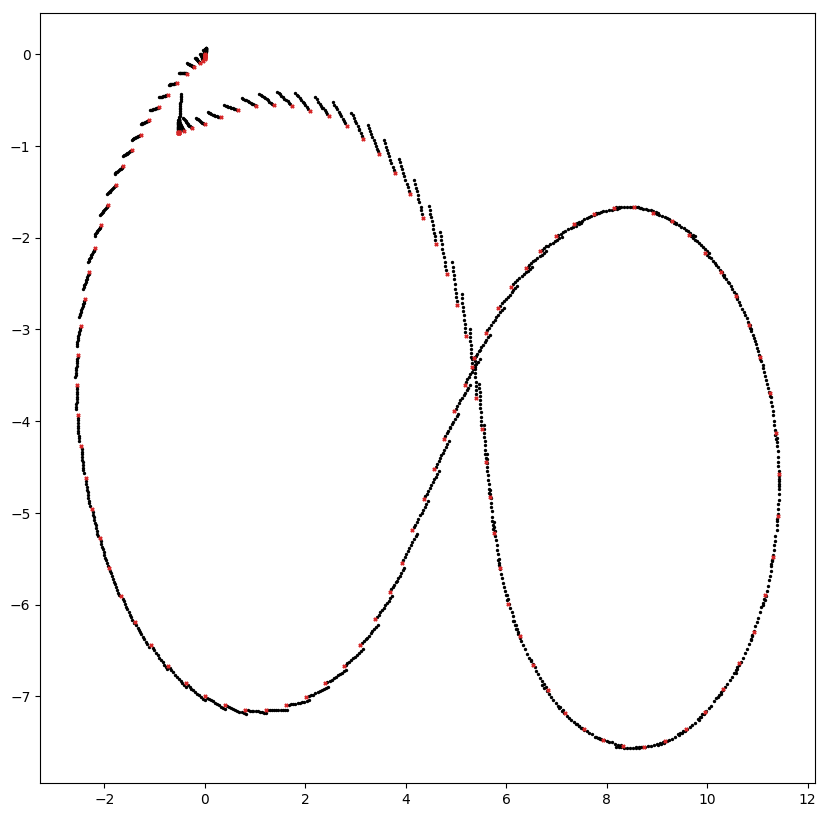

----------------------------------------------------------------------------------------------------
Generasi ke-2 dari 200
Matriks P generasi ke-3: [[9.48019286 0.         0.         0.         0.         0.
  9.1662215  0.         0.         0.         0.         0.
  9.32702214 0.         0.         0.         0.         0.
  9.50931734 0.         0.         0.         0.         0.
  1.03542926]]
Matriks Q generasi ke-3: [[ 9.11616751  0.          0.          0.          0.          0.
   9.44267287  0.          0.          0.          0.          0.
   8.29705081  0.          0.          0.          0.          0.
  10.89345992  0.          0.          0.          0.          0.
  -0.34772786]]
... logging to /home/win/.ros/log/e9d7a9a6-a4de-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-17848.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/src/localization_system/launc

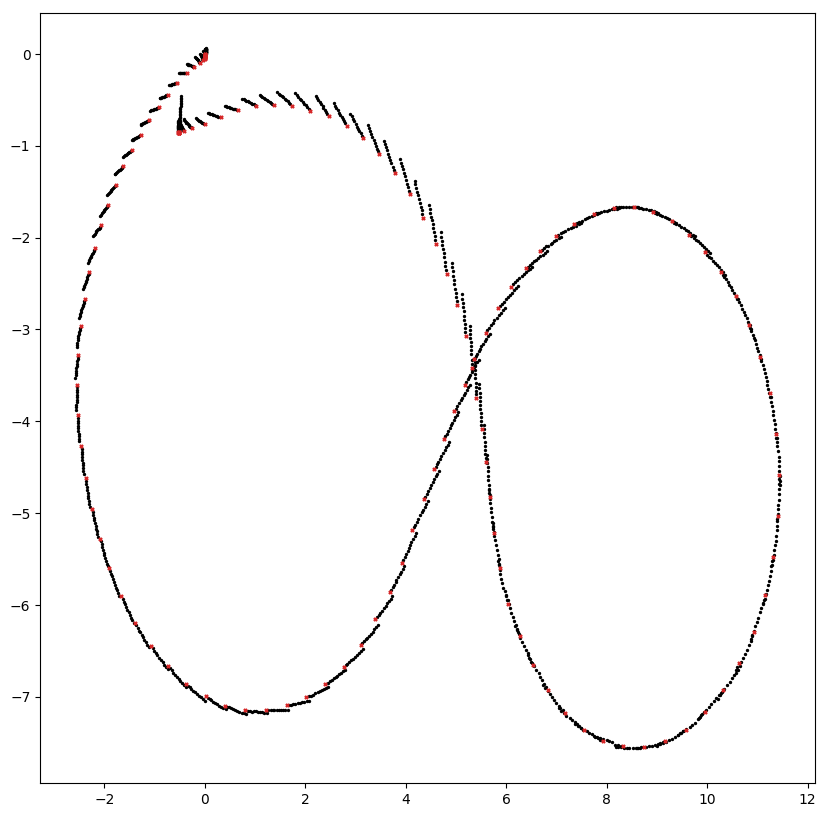

----------------------------------------------------------------------------------------------------
Generasi ke-3 dari 200
Matriks P generasi ke-4: [[ 9.12568116  0.          0.          0.          0.          0.
   9.60282035  0.          0.          0.          0.          0.
   9.88675859  0.          0.          0.          0.          0.
   9.66791145  0.          0.          0.          0.          0.
  -0.26871508]]
Matriks Q generasi ke-4: [[ 9.44406094  0.          0.          0.          0.          0.
  11.60679025  0.          0.          0.          0.          0.
   9.36536055  0.          0.          0.          0.          0.
   9.73890526  0.          0.          0.          0.          0.
   2.74266496]]
... logging to /home/win/.ros/log/fbd8655a-a4de-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-17940.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/src/

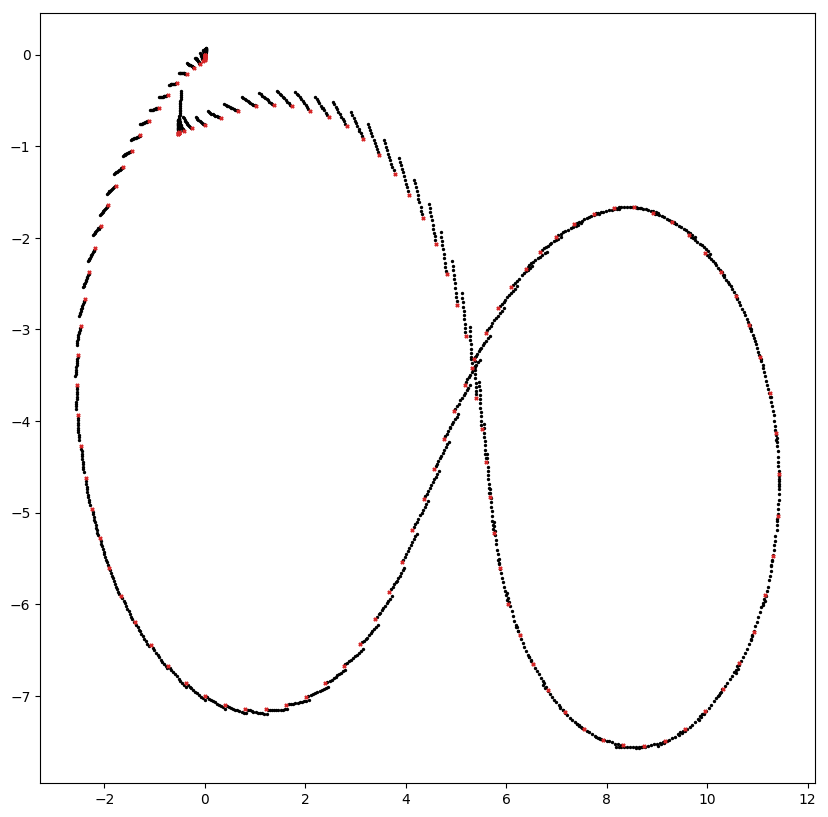

----------------------------------------------------------------------------------------------------
Generasi ke-4 dari 200
Matriks P generasi ke-5: [[ 9.63301393  0.          0.          0.          0.          0.
   8.85341145  0.          0.          0.          0.          0.
  10.52903726  0.          0.          0.          0.          0.
  10.49851914  0.          0.          0.          0.          0.
   1.64273799]]
Matriks Q generasi ke-5: [[ 9.80166548  0.          0.          0.          0.          0.
   8.72323896  0.          0.          0.          0.          0.
   6.53311937  0.          0.          0.          0.          0.
  13.18056257  0.          0.          0.          0.          0.
   0.3659422 ]]
... logging to /home/win/.ros/log/0dde334c-a4df-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-18038.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/src/

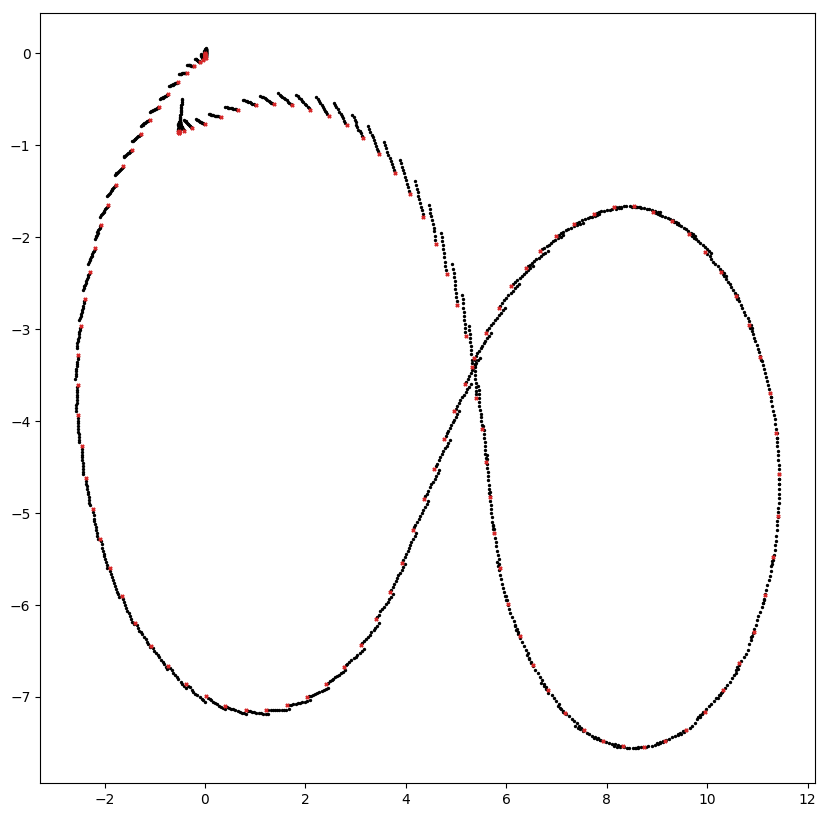

----------------------------------------------------------------------------------------------------
Generasi ke-5 dari 200
Matriks P generasi ke-6: [[10.77119117  0.          0.          0.          0.          0.
   8.44594463  0.          0.          0.          0.          0.
   9.13952645  0.          0.          0.          0.          0.
  10.1287058   0.          0.          0.          0.          0.
  -0.10653124]]
Matriks Q generasi ke-6: [[10.50948705  0.          0.          0.          0.          0.
   9.07776291  0.          0.          0.          0.          0.
   5.22411803  0.          0.          0.          0.          0.
  12.20199904  0.          0.          0.          0.          0.
   3.15359311]]
... logging to /home/win/.ros/log/1fd2b460-a4df-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-18127.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/src/

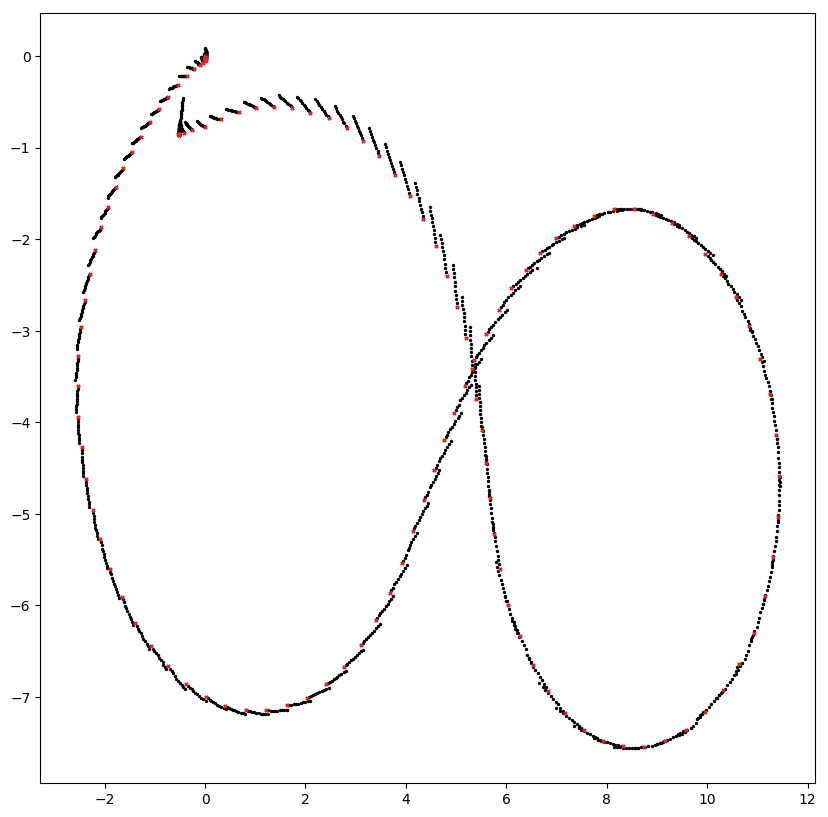

----------------------------------------------------------------------------------------------------
Generasi ke-6 dari 200
Matriks P generasi ke-7: [[ 7.61495359  0.          0.          0.          0.          0.
   8.03614787  0.          0.          0.          0.          0.
   9.3613727   0.          0.          0.          0.          0.
   9.20378775  0.          0.          0.          0.          0.
  -0.29693086]]
Matriks Q generasi ke-7: [[10.60859737  0.          0.          0.          0.          0.
   7.73033642  0.          0.          0.          0.          0.
   4.97481186  0.          0.          0.          0.          0.
  11.4724845   0.          0.          0.          0.          0.
   2.29070667]]
... logging to /home/win/.ros/log/31e86b68-a4df-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-18215.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/src/

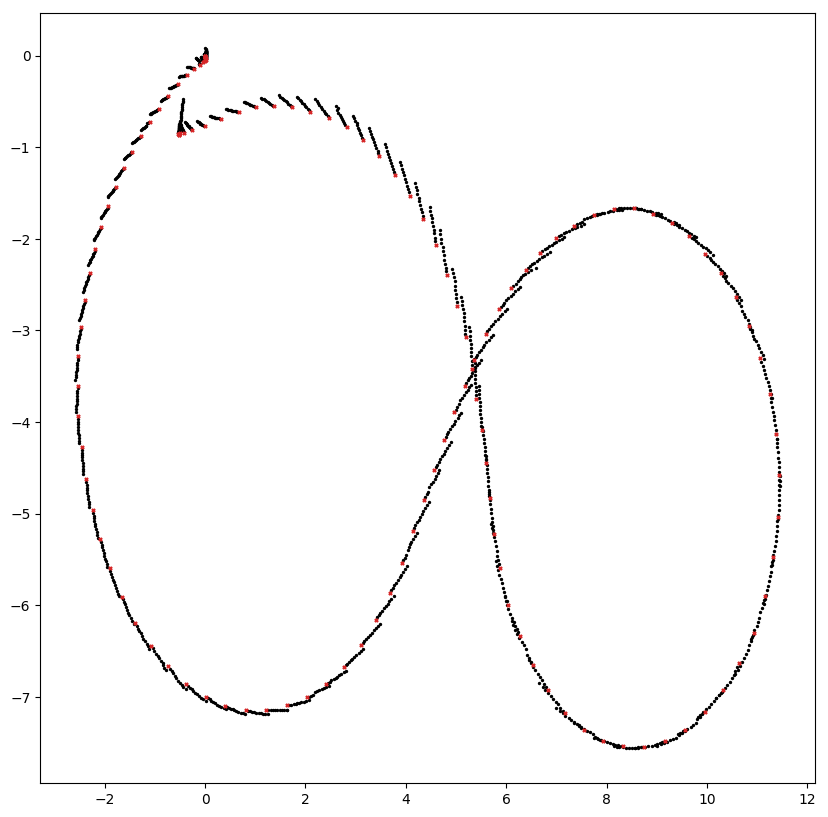

----------------------------------------------------------------------------------------------------
Generasi ke-7 dari 200
Matriks P generasi ke-8: [[ 8.50090198  0.          0.          0.          0.          0.
  10.12925398  0.          0.          0.          0.          0.
   9.80101369  0.          0.          0.          0.          0.
  10.11962089  0.          0.          0.          0.          0.
  -0.22373179]]
Matriks Q generasi ke-8: [[10.11737714  0.          0.          0.          0.          0.
  11.5204487   0.          0.          0.          0.          0.
   4.92020675  0.          0.          0.          0.          0.
  12.24358174  0.          0.          0.          0.          0.
   4.86420861]]
... logging to /home/win/.ros/log/4428a9a0-a4df-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-18303.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/src/

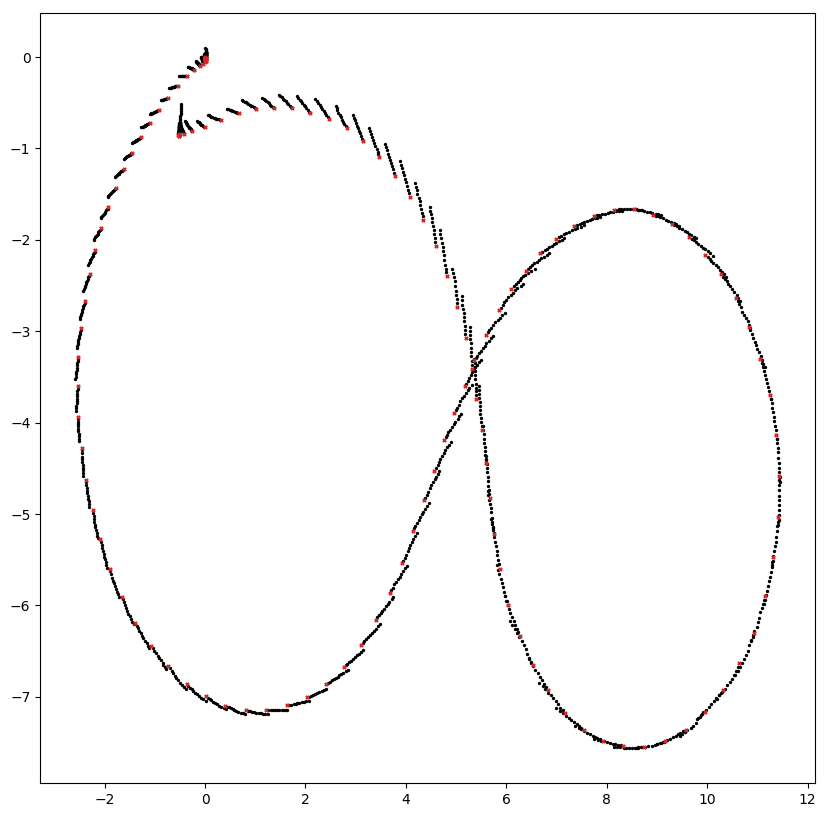

----------------------------------------------------------------------------------------------------
Generasi ke-8 dari 200
Matriks P generasi ke-9: [[11.14256158  0.          0.          0.          0.          0.
   9.65198084  0.          0.          0.          0.          0.
  10.96109133  0.          0.          0.          0.          0.
   8.75738178  0.          0.          0.          0.          0.
   1.42052205]]
Matriks Q generasi ke-9: [[10.45964579  0.          0.          0.          0.          0.
  10.02678182  0.          0.          0.          0.          0.
   3.16737616  0.          0.          0.          0.          0.
  10.25086918  0.          0.          0.          0.          0.
   4.22091388]]
... logging to /home/win/.ros/log/563bfd7c-a4df-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-18397.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/src/

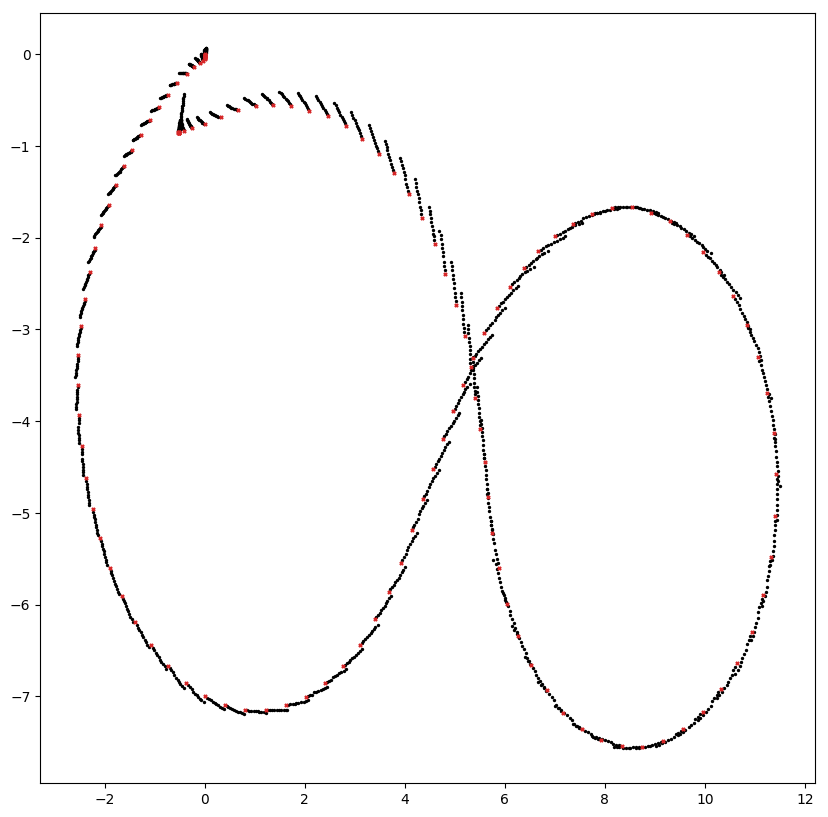

----------------------------------------------------------------------------------------------------
Generasi ke-9 dari 200
Matriks P generasi ke-10: [[ 9.68939479  0.          0.          0.          0.          0.
   9.10324069  0.          0.          0.          0.          0.
   8.82912967  0.          0.          0.          0.          0.
  10.18767153  0.          0.          0.          0.          0.
  -1.21338479]]
Matriks Q generasi ke-10: [[11.07121175  0.          0.          0.          0.          0.
   9.96601827  0.          0.          0.          0.          0.
   4.09387967  0.          0.          0.          0.          0.
  10.71005447  0.          0.          0.          0.          0.
   3.94012671]]
... logging to /home/win/.ros/log/682e94ea-a4df-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-18488.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/sr

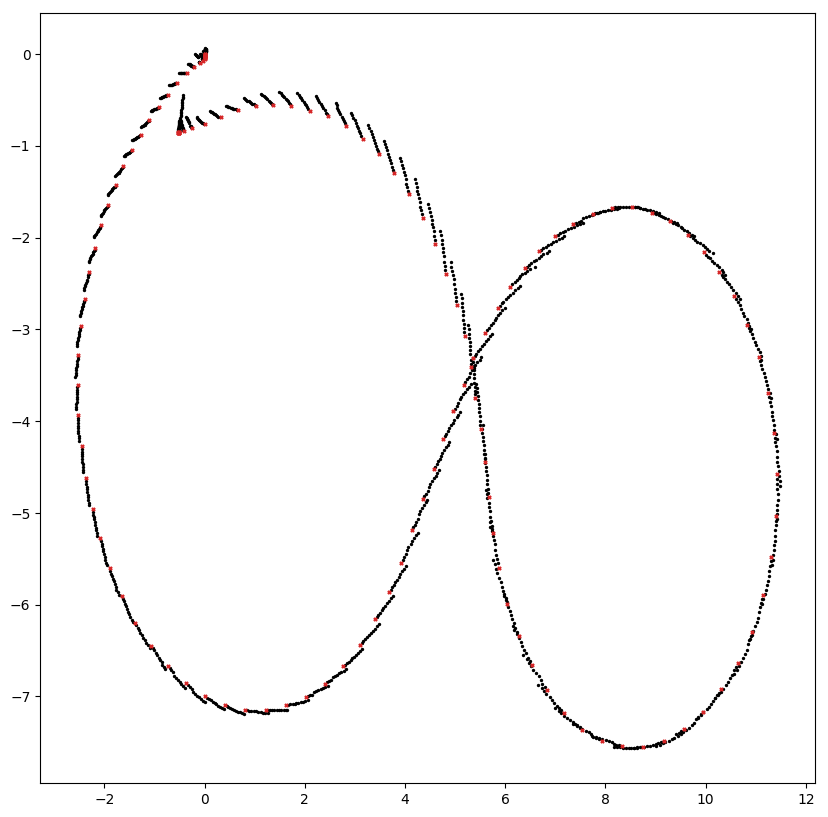

----------------------------------------------------------------------------------------------------
Generasi ke-10 dari 200
Matriks P generasi ke-11: [[ 9.97205009  0.          0.          0.          0.          0.
   7.79321715  0.          0.          0.          0.          0.
   9.21288948  0.          0.          0.          0.          0.
   8.73492282  0.          0.          0.          0.          0.
  -0.25645962]]
Matriks Q generasi ke-11: [[ 8.11750565  0.          0.          0.          0.          0.
  11.73231013  0.          0.          0.          0.          0.
   5.63644996  0.          0.          0.          0.          0.
   9.57729963  0.          0.          0.          0.          0.
  -0.15972252]]
... logging to /home/win/.ros/log/7a3f4c4c-a4df-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-18609.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/s

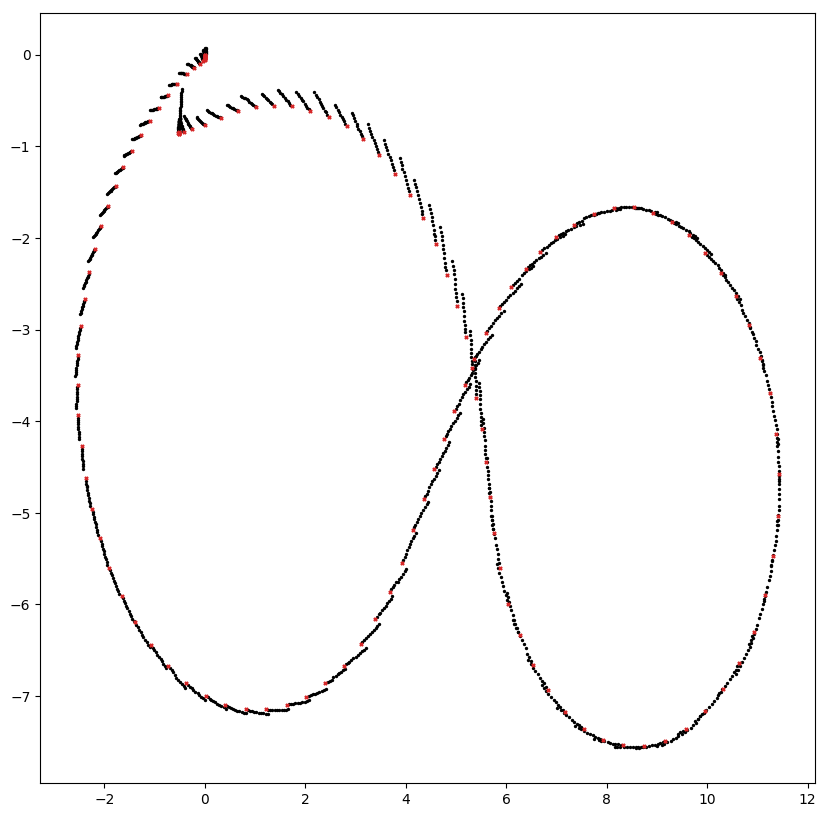

----------------------------------------------------------------------------------------------------
Generasi ke-11 dari 200
Matriks P generasi ke-12: [[11.0430923   0.          0.          0.          0.          0.
   8.81784713  0.          0.          0.          0.          0.
  10.61673687  0.          0.          0.          0.          0.
   9.40569117  0.          0.          0.          0.          0.
  -1.14286472]]
Matriks Q generasi ke-12: [[ 9.32864037  0.          0.          0.          0.          0.
  11.10789744  0.          0.          0.          0.          0.
  10.41169955  0.          0.          0.          0.          0.
  10.03380612  0.          0.          0.          0.          0.
   4.19220297]]
... logging to /home/win/.ros/log/8c35264c-a4df-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-18698.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/s

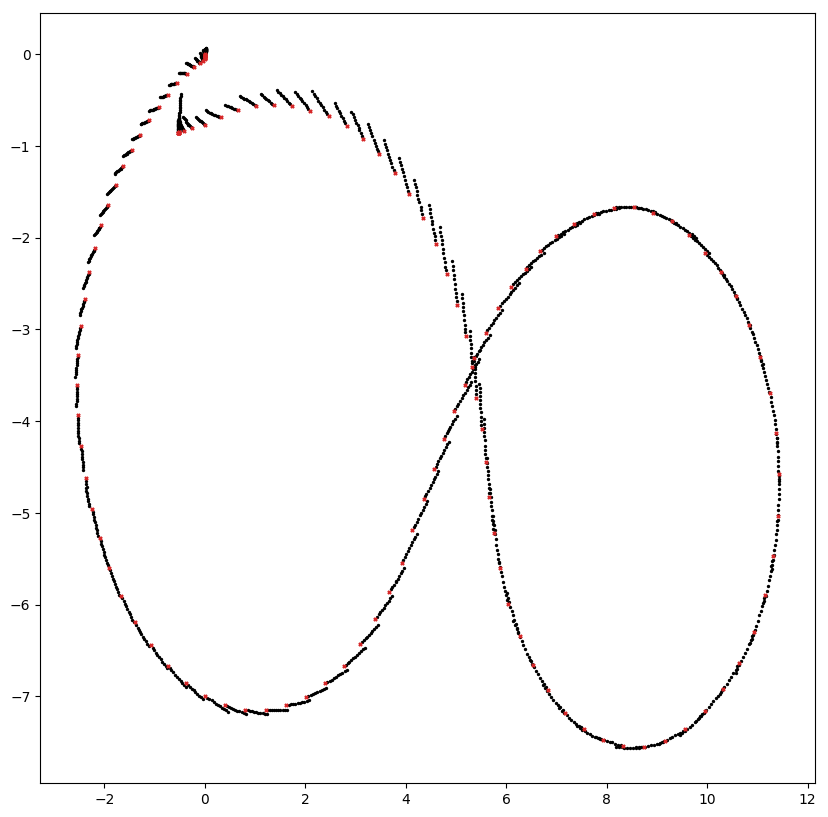

----------------------------------------------------------------------------------------------------
Generasi ke-12 dari 200
Matriks P generasi ke-13: [[10.49483029  0.          0.          0.          0.          0.
  11.06754474  0.          0.          0.          0.          0.
  10.99784041  0.          0.          0.          0.          0.
  10.61218917  0.          0.          0.          0.          0.
   1.62859175]]
Matriks Q generasi ke-13: [[ 8.22875591  0.          0.          0.          0.          0.
  11.36465601  0.          0.          0.          0.          0.
  11.80413473  0.          0.          0.          0.          0.
   9.09725935  0.          0.          0.          0.          0.
   4.98963429]]
... logging to /home/win/.ros/log/9e35d80a-a4df-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-18787.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/s

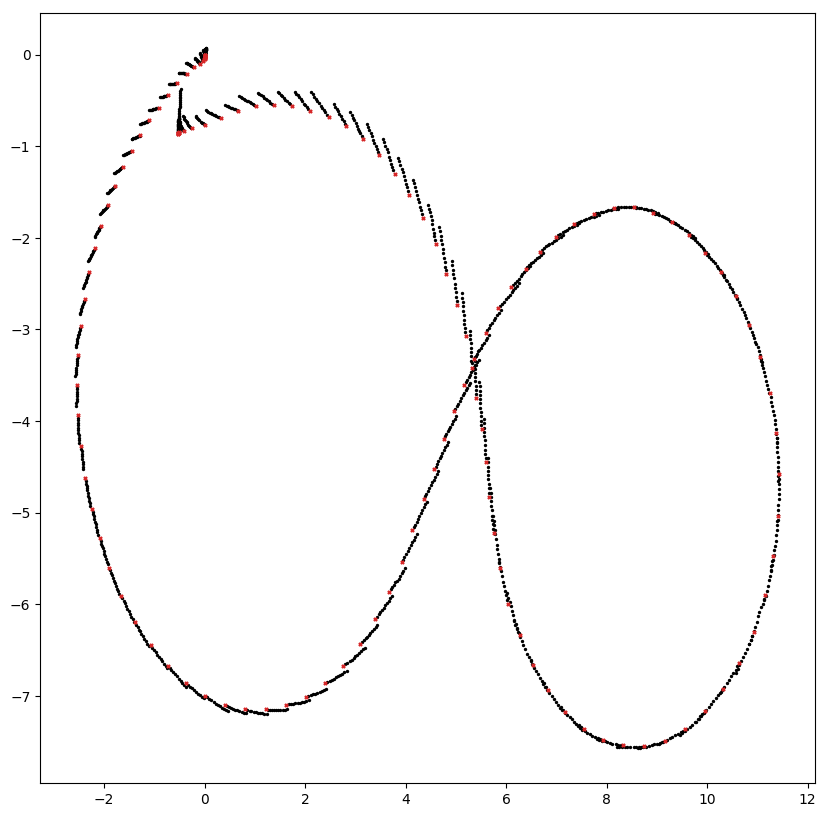

----------------------------------------------------------------------------------------------------
Generasi ke-13 dari 200
Matriks P generasi ke-14: [[ 9.7410634   0.          0.          0.          0.          0.
   6.58794463  0.          0.          0.          0.          0.
   8.49993766  0.          0.          0.          0.          0.
  10.12864222  0.          0.          0.          0.          0.
   0.52467881]]
Matriks Q generasi ke-14: [[ 9.48688623  0.          0.          0.          0.          0.
  11.1315016   0.          0.          0.          0.          0.
  10.40157781  0.          0.          0.          0.          0.
   9.8189899   0.          0.          0.          0.          0.
   2.07779581]]
... logging to /home/win/.ros/log/b01bc8f4-a4df-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-18875.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/s

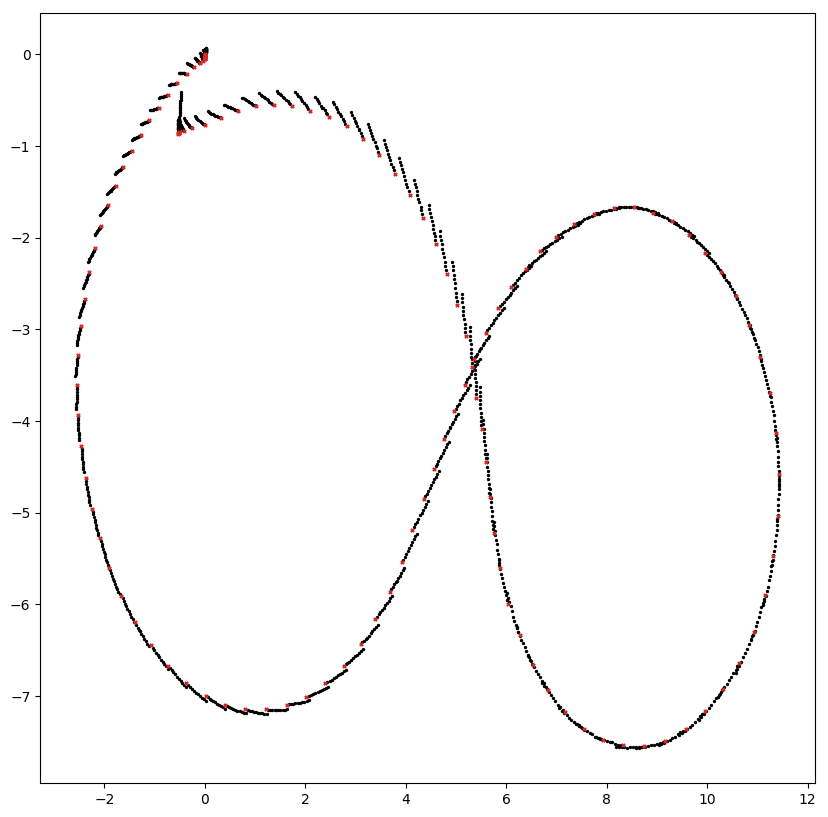

----------------------------------------------------------------------------------------------------
Generasi ke-14 dari 200
Matriks P generasi ke-15: [[11.44505887  0.          0.          0.          0.          0.
   8.4034603   0.          0.          0.          0.          0.
   9.56115797  0.          0.          0.          0.          0.
   9.2684425   0.          0.          0.          0.          0.
   0.03002219]]
Matriks Q generasi ke-15: [[10.94430418  0.          0.          0.          0.          0.
   8.28836513  0.          0.          0.          0.          0.
   3.89601333  0.          0.          0.          0.          0.
  11.9857989   0.          0.          0.          0.          0.
   2.07660507]]
... logging to /home/win/.ros/log/c21e4e00-a4df-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-18966.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/s

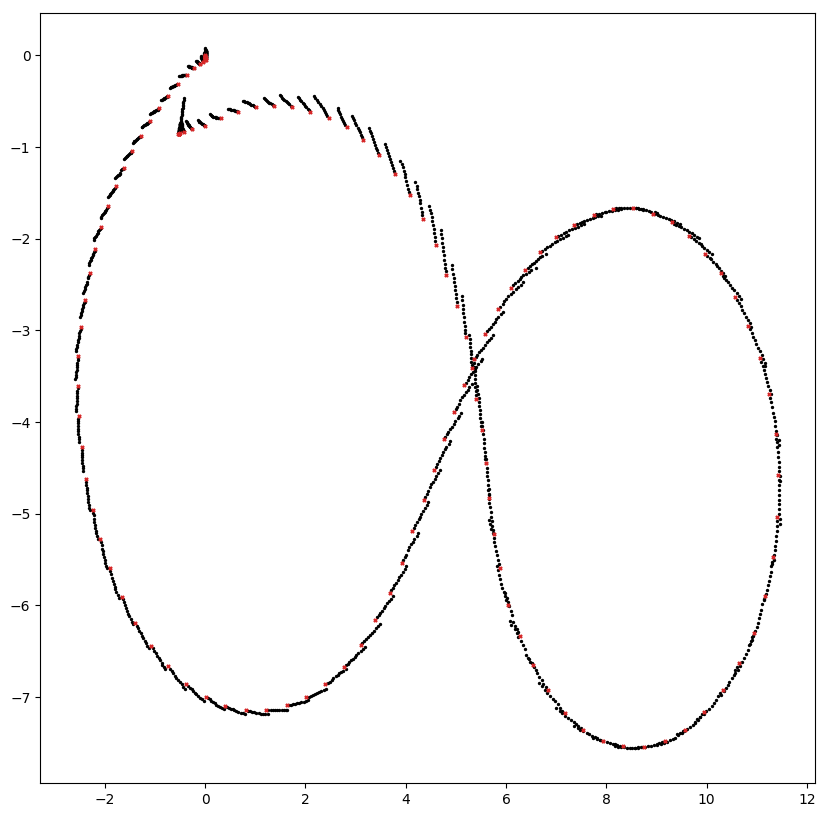

----------------------------------------------------------------------------------------------------
Generasi ke-15 dari 200
Matriks P generasi ke-16: [[10.43093579  0.          0.          0.          0.          0.
   7.24985726  0.          0.          0.          0.          0.
   9.75970752  0.          0.          0.          0.          0.
   9.83195525  0.          0.          0.          0.          0.
  -0.4907559 ]]
Matriks Q generasi ke-16: [[ 8.66613805  0.          0.          0.          0.          0.
  10.12513498  0.          0.          0.          0.          0.
  11.35711633  0.          0.          0.          0.          0.
  11.25482449  0.          0.          0.          0.          0.
   3.4537032 ]]
... logging to /home/win/.ros/log/d42f7664-a4df-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-19055.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/s

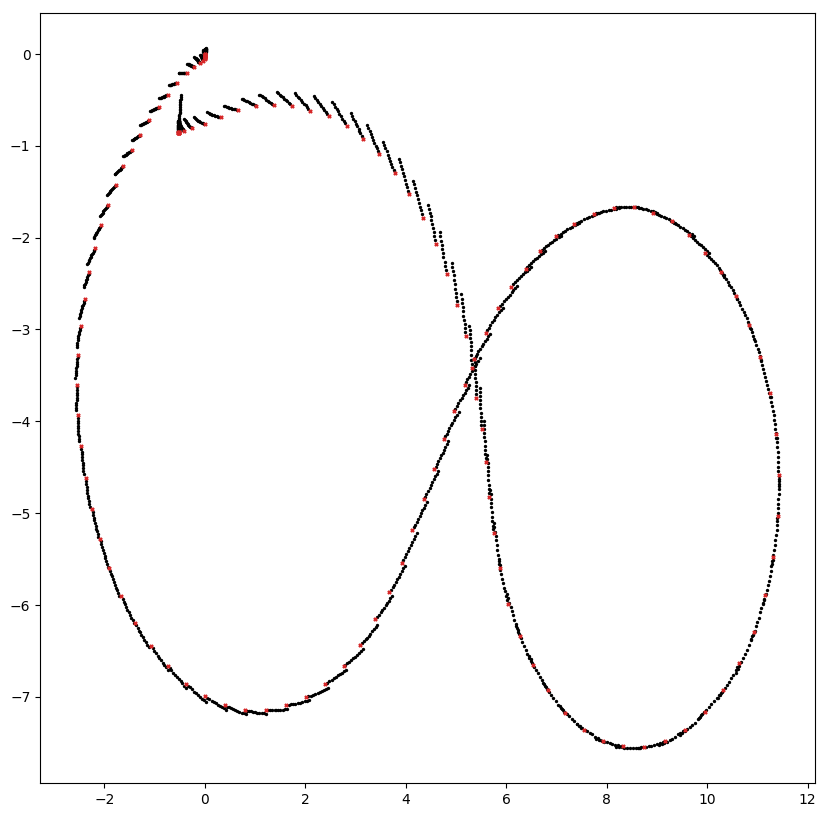

----------------------------------------------------------------------------------------------------
Generasi ke-16 dari 200
Matriks P generasi ke-17: [[ 6.24153093  0.          0.          0.          0.          0.
   8.4805982   0.          0.          0.          0.          0.
  10.77072986  0.          0.          0.          0.          0.
   8.65681066  0.          0.          0.          0.          0.
   0.86088709]]
Matriks Q generasi ke-17: [[5.51164594 0.         0.         0.         0.         0.
  7.13455292 0.         0.         0.         0.         0.
  4.9404874  0.         0.         0.         0.         0.
  9.83739857 0.         0.         0.         0.         0.
  2.52411622]]
... logging to /home/win/.ros/log/e62199a6-a4df-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-19144.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/src/localization_system/la

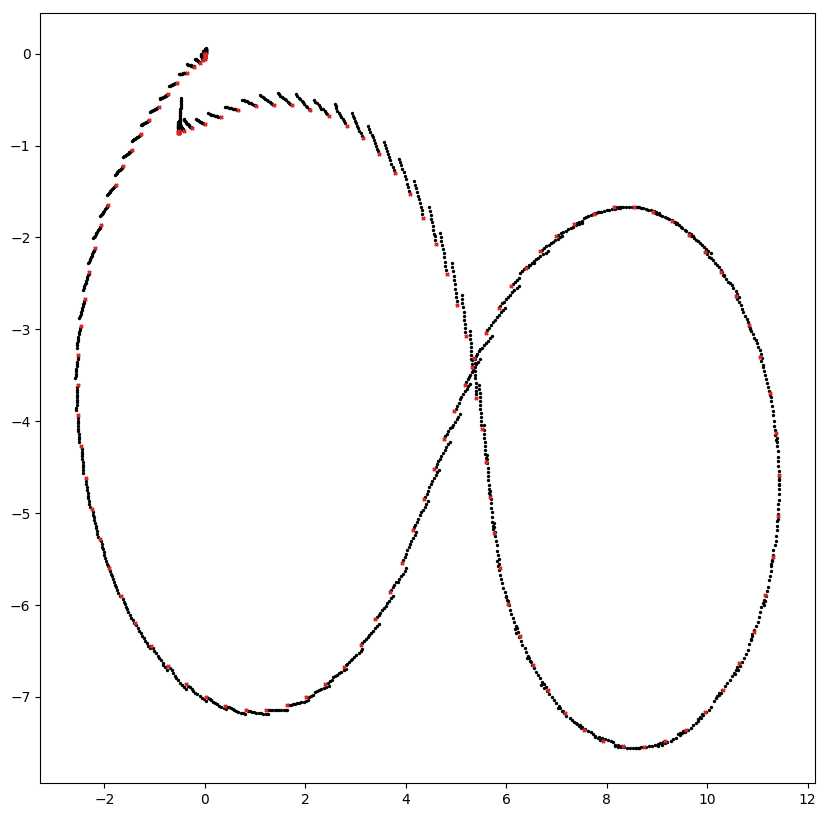

----------------------------------------------------------------------------------------------------
Generasi ke-17 dari 200
Matriks P generasi ke-18: [[ 7.66506244  0.          0.          0.          0.          0.
   8.46187427  0.          0.          0.          0.          0.
   9.59280946  0.          0.          0.          0.          0.
  10.13043872  0.          0.          0.          0.          0.
   0.90054306]]
Matriks Q generasi ke-18: [[ 9.20237638  0.          0.          0.          0.          0.
  11.68912889  0.          0.          0.          0.          0.
  10.3036139   0.          0.          0.          0.          0.
  10.04096469  0.          0.          0.          0.          0.
   4.83997721]]
... logging to /home/win/.ros/log/f8045a6e-a4df-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-19233.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/s

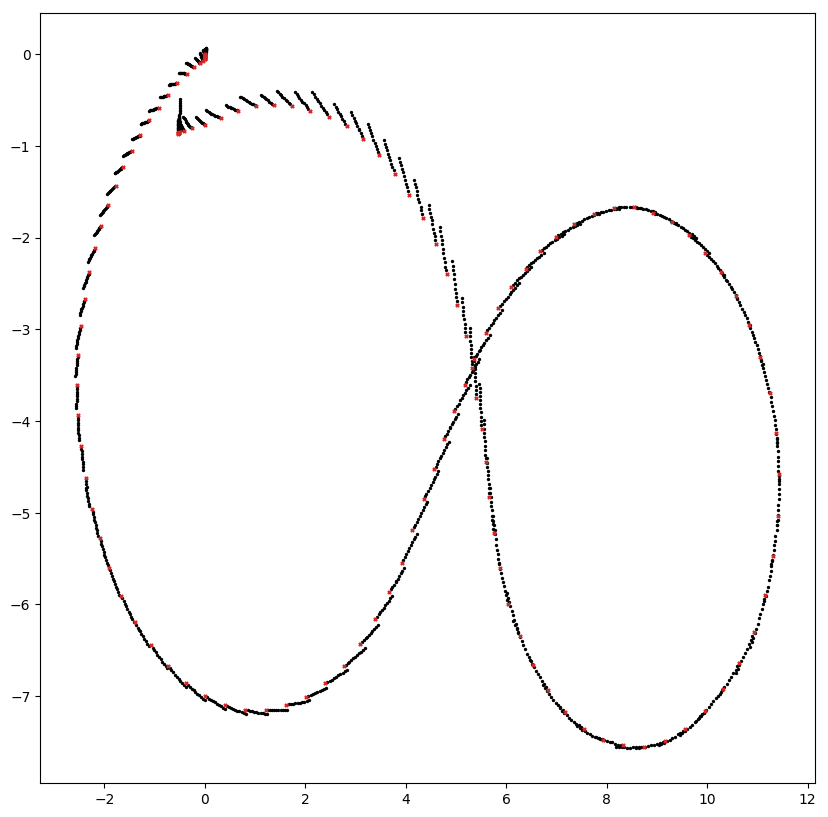

----------------------------------------------------------------------------------------------------
Generasi ke-18 dari 200
Matriks P generasi ke-19: [[ 8.42559402  0.          0.          0.          0.          0.
   9.24583145  0.          0.          0.          0.          0.
  11.53987898  0.          0.          0.          0.          0.
   9.76601755  0.          0.          0.          0.          0.
   2.4938496 ]]
Matriks Q generasi ke-19: [[ 9.77094734  0.          0.          0.          0.          0.
   9.9025606   0.          0.          0.          0.          0.
  11.01700812  0.          0.          0.          0.          0.
   9.81805591  0.          0.          0.          0.          0.
   3.35530973]]
... logging to /home/win/.ros/log/0a0155dc-a4e0-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-19321.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/s

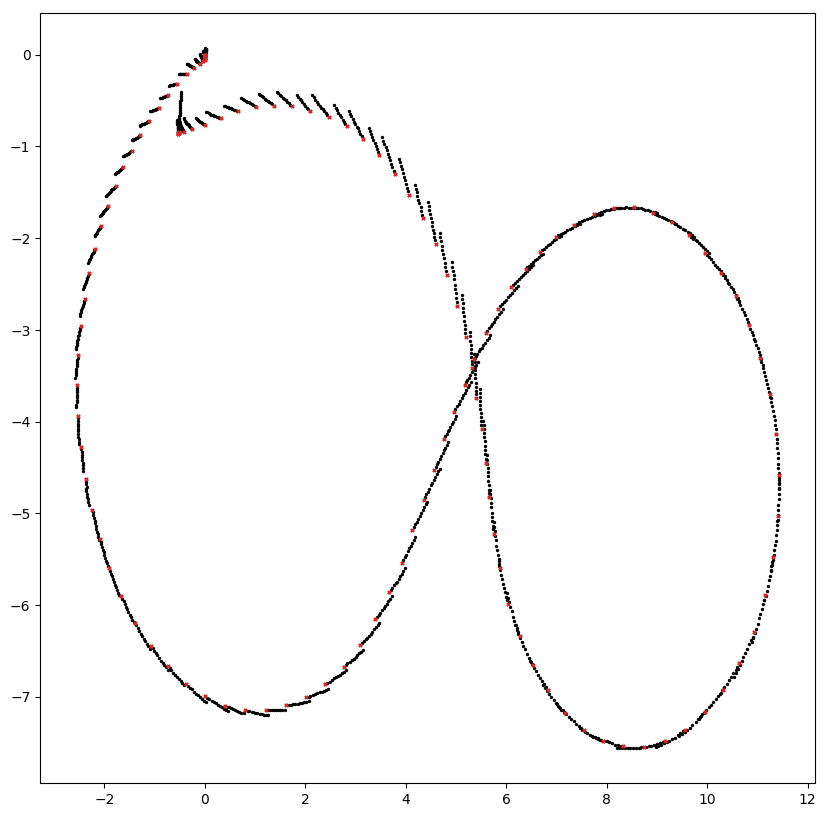

----------------------------------------------------------------------------------------------------
Generasi ke-19 dari 200
Matriks P generasi ke-20: [[ 9.09734279  0.          0.          0.          0.          0.
   8.10938683  0.          0.          0.          0.          0.
   9.5341944   0.          0.          0.          0.          0.
  10.52169011  0.          0.          0.          0.          0.
   1.12179896]]
Matriks Q generasi ke-20: [[ 9.03251742  0.          0.          0.          0.          0.
   8.98171082  0.          0.          0.          0.          0.
   9.5438848   0.          0.          0.          0.          0.
  11.9794383   0.          0.          0.          0.          0.
   4.41811128]]
... logging to /home/win/.ros/log/1be69064-a4e0-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-19410.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/s

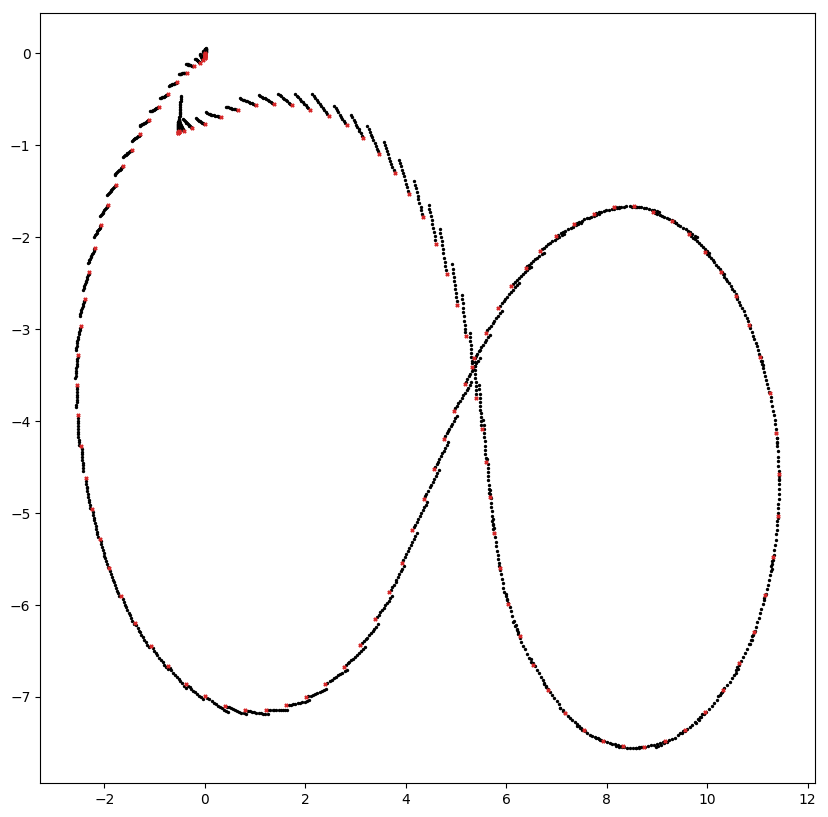

----------------------------------------------------------------------------------------------------
Generasi ke-20 dari 200
Matriks P generasi ke-21: [[ 9.30943699  0.          0.          0.          0.          0.
  10.48958042  0.          0.          0.          0.          0.
   8.15367879  0.          0.          0.          0.          0.
   9.62315954  0.          0.          0.          0.          0.
  -0.89856016]]
Matriks Q generasi ke-21: [[ 7.97606151  0.          0.          0.          0.          0.
  10.31257414  0.          0.          0.          0.          0.
   9.09517105  0.          0.          0.          0.          0.
   9.27823955  0.          0.          0.          0.          0.
   1.85724714]]
... logging to /home/win/.ros/log/2dfa0e2a-a4e0-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-19528.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/s

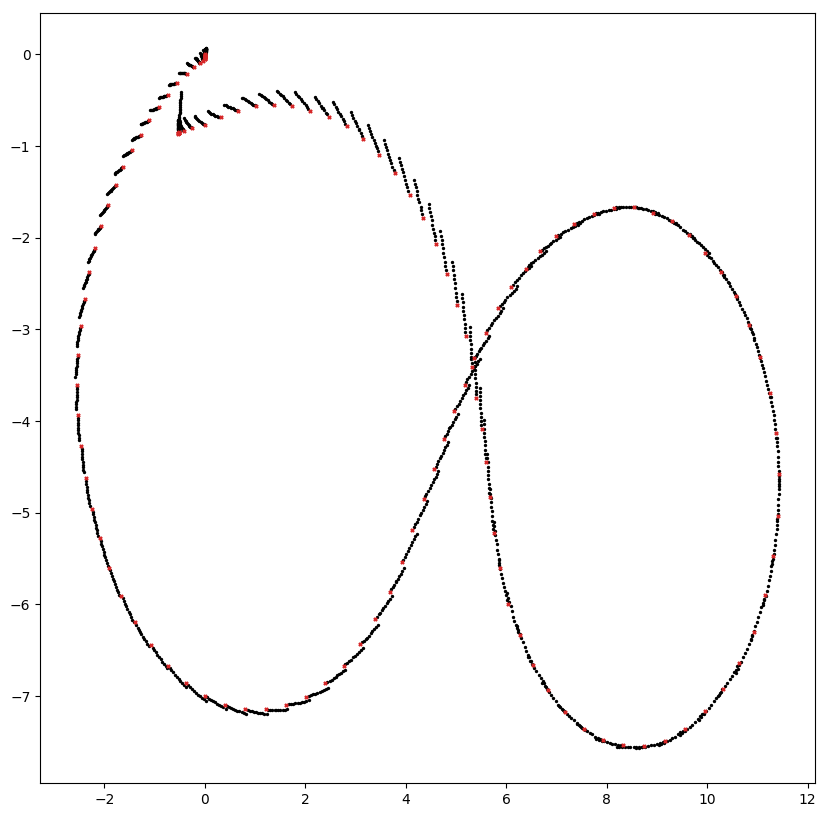

----------------------------------------------------------------------------------------------------
Generasi ke-21 dari 200
Matriks P generasi ke-22: [[10.14121665  0.          0.          0.          0.          0.
   6.76820975  0.          0.          0.          0.          0.
   9.87845667  0.          0.          0.          0.          0.
  11.09385629  0.          0.          0.          0.          0.
   1.29774477]]
Matriks Q generasi ke-22: [[10.70457658  0.          0.          0.          0.          0.
   8.88767998  0.          0.          0.          0.          0.
   5.93280765  0.          0.          0.          0.          0.
   9.55355709  0.          0.          0.          0.          0.
   1.91546657]]
... logging to /home/win/.ros/log/3fdeb23a-a4e0-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-19618.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/s

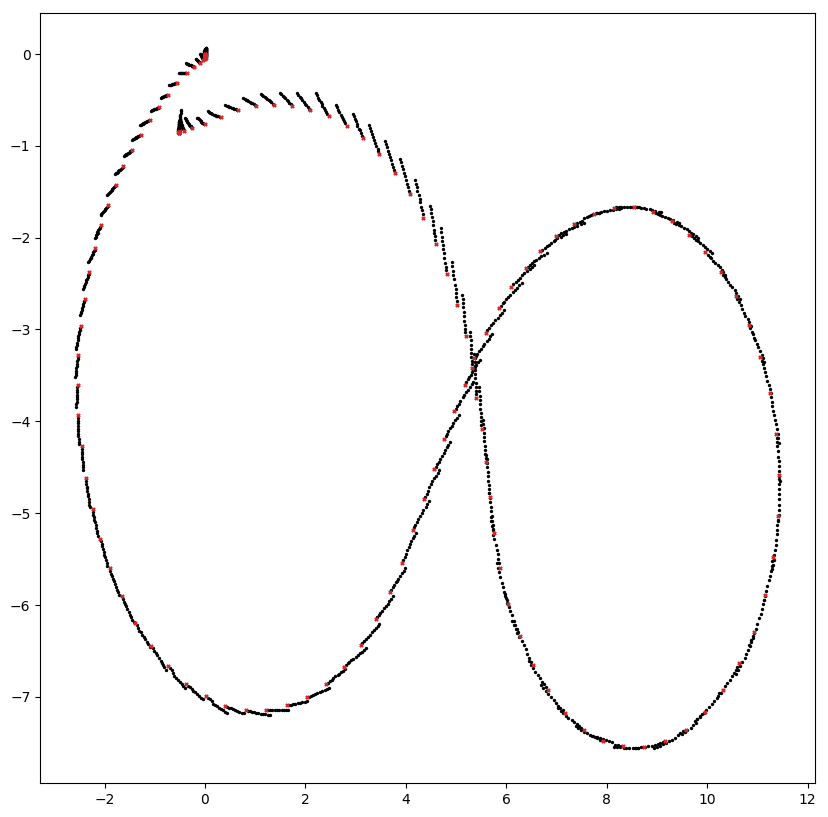

----------------------------------------------------------------------------------------------------
Generasi ke-22 dari 200
Matriks P generasi ke-23: [[ 9.4974166   0.          0.          0.          0.          0.
   5.89344936  0.          0.          0.          0.          0.
   9.34787615  0.          0.          0.          0.          0.
  10.953227    0.          0.          0.          0.          0.
   1.9429609 ]]
Matriks Q generasi ke-23: [[ 9.32805749  0.          0.          0.          0.          0.
   8.52584923  0.          0.          0.          0.          0.
   9.32860769  0.          0.          0.          0.          0.
  12.01379657  0.          0.          0.          0.          0.
   0.1777381 ]]
... logging to /home/win/.ros/log/51c3b932-a4e0-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-19706.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/s

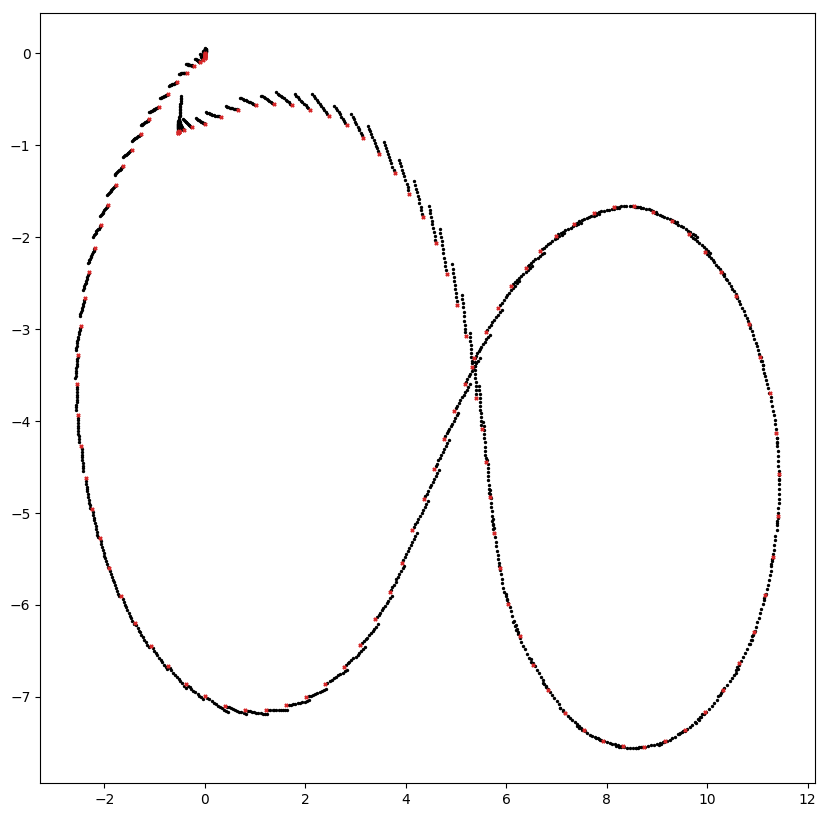

----------------------------------------------------------------------------------------------------
Generasi ke-23 dari 200
Matriks P generasi ke-24: [[10.02913424  0.          0.          0.          0.          0.
   8.62338566  0.          0.          0.          0.          0.
  11.0004478   0.          0.          0.          0.          0.
  10.44756802  0.          0.          0.          0.          0.
   2.59560353]]
Matriks Q generasi ke-24: [[10.36770915  0.          0.          0.          0.          0.
  11.46628092  0.          0.          0.          0.          0.
   4.81118042  0.          0.          0.          0.          0.
  15.3780137   0.          0.          0.          0.          0.
   5.28598889]]
... logging to /home/win/.ros/log/63d36cc6-a4e0-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-19797.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/s

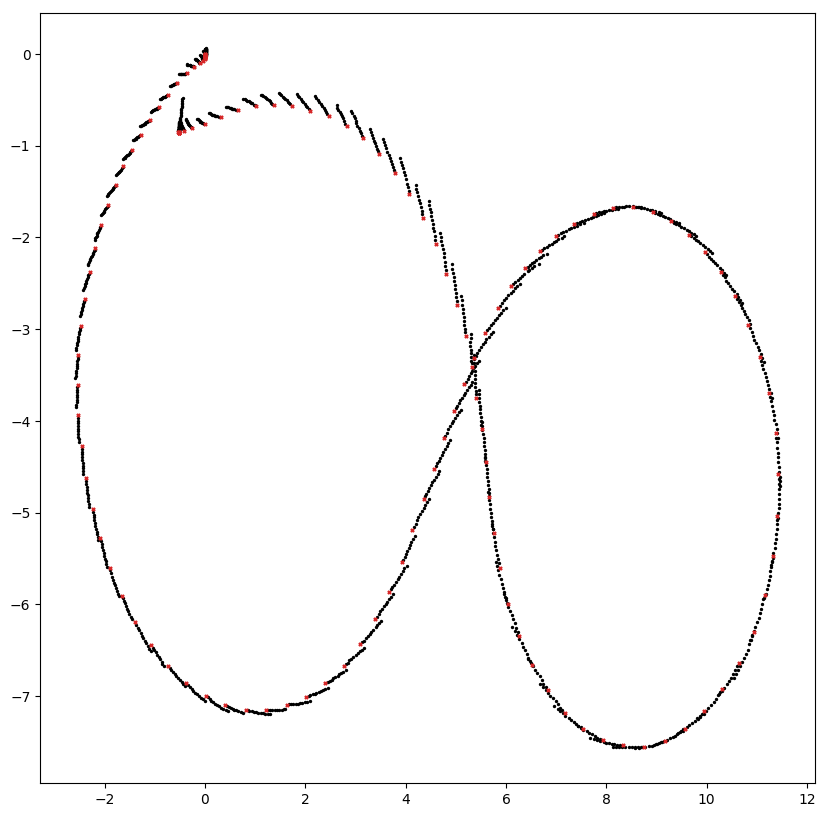

----------------------------------------------------------------------------------------------------
Generasi ke-24 dari 200
Matriks P generasi ke-25: [[8.78780902 0.         0.         0.         0.         0.
  7.90059539 0.         0.         0.         0.         0.
  8.99442084 0.         0.         0.         0.         0.
  8.66084164 0.         0.         0.         0.         0.
  0.14705179]]
Matriks Q generasi ke-25: [[10.7882206   0.          0.          0.          0.          0.
  11.80089433  0.          0.          0.          0.          0.
   8.85140326  0.          0.          0.          0.          0.
   8.92798494  0.          0.          0.          0.          0.
  -0.37814184]]
... logging to /home/win/.ros/log/75d2de48-a4e0-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-19886.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/src/localization_system/la

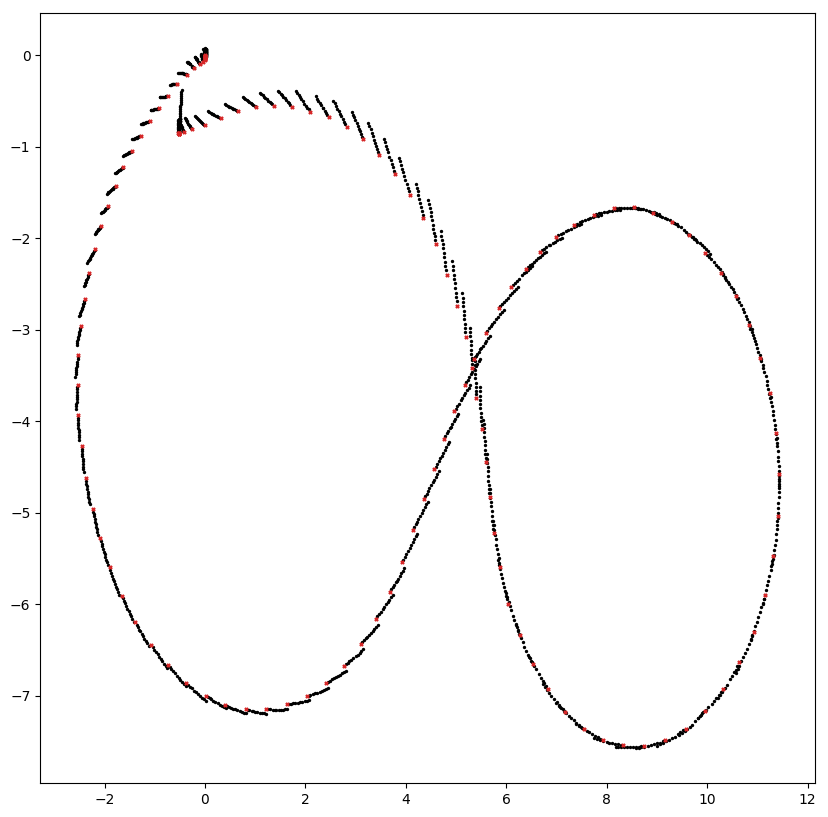

----------------------------------------------------------------------------------------------------
Generasi ke-25 dari 200
Matriks P generasi ke-26: [[12.02751787  0.          0.          0.          0.          0.
   8.84220432  0.          0.          0.          0.          0.
   9.24094076  0.          0.          0.          0.          0.
  10.49326069  0.          0.          0.          0.          0.
  -0.08800421]]
Matriks Q generasi ke-26: [[11.22435487  0.          0.          0.          0.          0.
  10.22007963  0.          0.          0.          0.          0.
   5.56043665  0.          0.          0.          0.          0.
  12.09280639  0.          0.          0.          0.          0.
   2.20500395]]
... logging to /home/win/.ros/log/87b95182-a4e0-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-19974.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/s

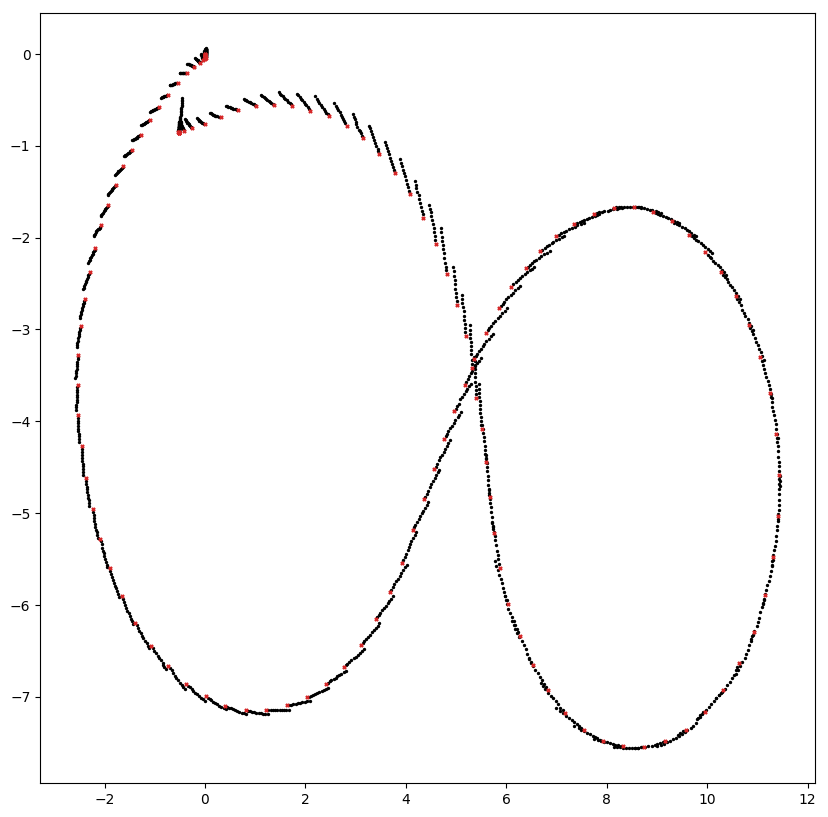

----------------------------------------------------------------------------------------------------
Generasi ke-26 dari 200
Matriks P generasi ke-27: [[10.029   0.      0.      0.      0.      0.      8.1094  0.      0.
   0.      0.      0.      9.5342  0.      0.      0.      0.      0.
  10.448   0.      0.      0.      0.      0.      1.1218]]
Matriks Q generasi ke-27: [[ 9.0325  0.      0.      0.      0.      0.      8.9817  0.      0.
   0.      0.      0.      9.5439  0.      0.      0.      0.      0.
  15.378   0.      0.      0.      0.      0.      5.286 ]]
... logging to /home/win/.ros/log/99c4dfd6-a4e0-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-20062.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/src/localization_system/launch/launch_for_ga.launch
started roslaunch server http://win-ubuntu:39215/

SUMMARY

CLEAR PARAMETERS
 * /rosbag_play/
 * /rosbag_rec

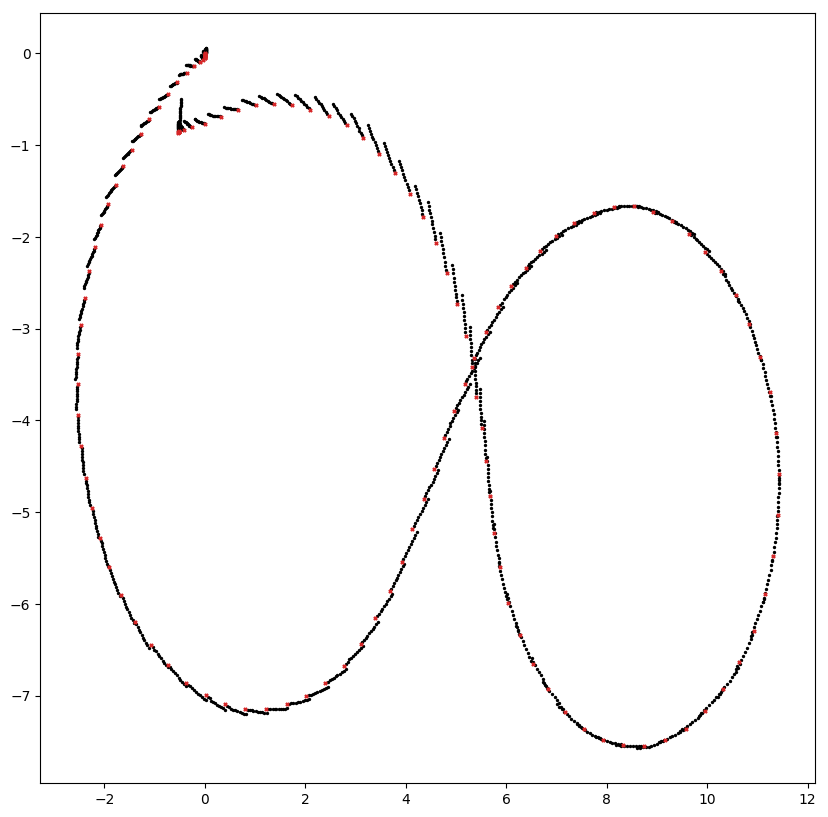

----------------------------------------------------------------------------------------------------
Generasi ke-27 dari 200
Matriks P generasi ke-28: [[9.1257 0.     0.     0.     0.     0.     8.1094 0.     0.     0.
  0.     0.     9.5342 0.     0.     0.     0.     0.     9.6679 0.
  0.     0.     0.     0.     1.1218]]
Matriks Q generasi ke-28: [[9.4441 0.     0.     0.     0.     0.     8.9817 0.     0.     0.
  0.     0.     9.5439 0.     0.     0.     0.     0.     9.7389 0.
  0.     0.     0.     0.     2.7427]]
... logging to /home/win/.ros/log/abc8ef42-a4e0-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-20151.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/src/localization_system/launch/launch_for_ga.launch
started roslaunch server http://win-ubuntu:39815/

SUMMARY

CLEAR PARAMETERS
 * /rosbag_play/
 * /rosbag_record/

PARAMETERS
 * /R_gnss: [0.0001, 0, 0, 0....


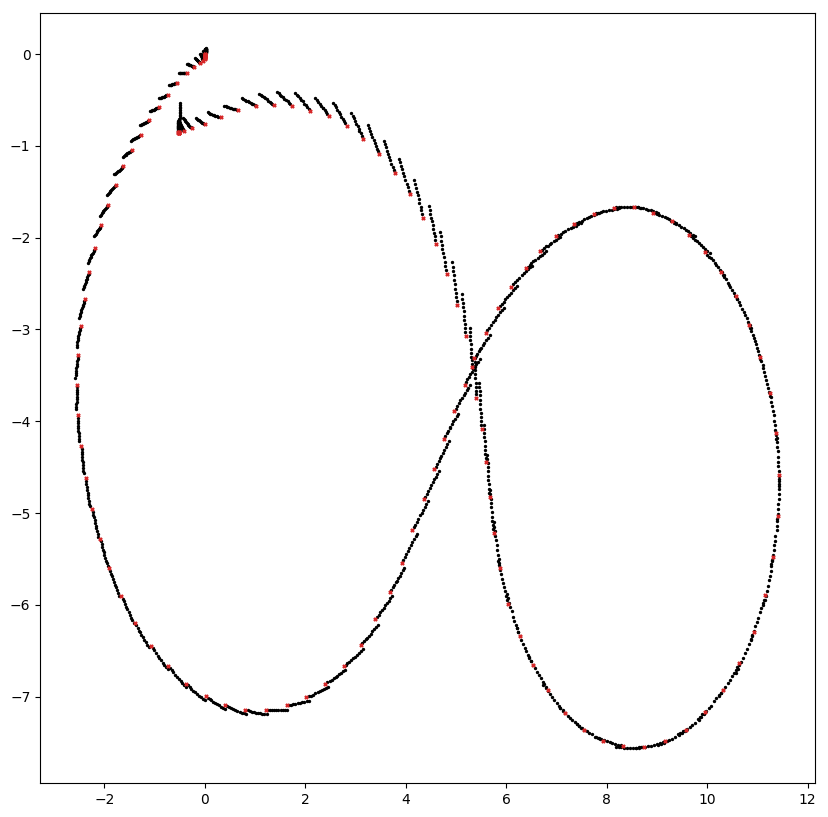

----------------------------------------------------------------------------------------------------
Generasi ke-28 dari 200
Matriks P generasi ke-29: [[9.62195946 0.         0.         0.         0.         0.
  9.94365624 0.         0.         0.         0.         0.
  7.40208456 0.         0.         0.         0.         0.
  8.60790879 0.         0.         0.         0.         0.
  0.44846753]]
Matriks Q generasi ke-29: [[ 8.77242467  0.          0.          0.          0.          0.
  10.87060675  0.          0.          0.          0.          0.
  11.47847535  0.          0.          0.          0.          0.
   8.96790953  0.          0.          0.          0.          0.
   1.2057253 ]]
... logging to /home/win/.ros/log/bdba002e-a4e0-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-20240.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/src/localization_system/la

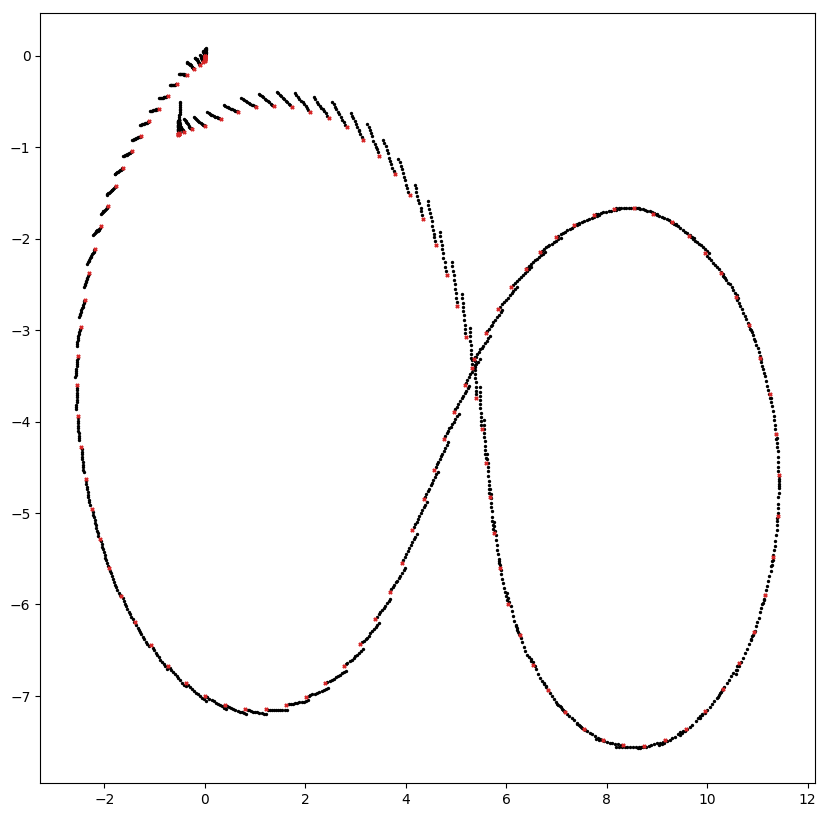

----------------------------------------------------------------------------------------------------
Generasi ke-29 dari 200
Matriks P generasi ke-30: [[ 9.68326558  0.          0.          0.          0.          0.
   8.90646421  0.          0.          0.          0.          0.
   8.16191264  0.          0.          0.          0.          0.
   9.79585989  0.          0.          0.          0.          0.
  -0.47165132]]
Matriks Q generasi ke-30: [[ 6.96594859  0.          0.          0.          0.          0.
   9.24207039  0.          0.          0.          0.          0.
  10.506387    0.          0.          0.          0.          0.
   9.78370566  0.          0.          0.          0.          0.
  -0.32967417]]
... logging to /home/win/.ros/log/cf98edbe-a4e0-11eb-a7d6-f0038c0a96db/roslaunch-win-ubuntu-20328.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/s

In [ ]:

# initializing the parameter values
p_diagonals = [10, 10, 10, 10, 1]
q_diagonals = [10, 10, 10, 10, 1]
p_temp, q_temp = init_pq(p_diagonals, q_diagonals)

wd = os.getcwd() #the working directory (wd) and 
pwd = os.path.dirname(wd) #the parent of the wd (pwd)

# define the max number of generations
temp_folder = pwd + "/logs/"
clear_path(temp_folder)

params = ['p', 'q']
errors_saved = ['error', 'error_bygen']
temp_names = params + ['fitness'] + errors_saved
to_load = params + ['fitness']

# defining the filename for the values temps to be saved with
path = {}
for temp in temp_names:
    path[temp] = temp_folder + temp + '_path.txt'

generasi = 200
for g in range(1, generasi+1):
    print("----------------------------------------------------------------------------------------------------")
    print("Generasi ke-"+ str(g) + " dari " + str(generasi))

    if os.path.exists(path['p']): # load the saved parameters after the 1st generation
        # backbone of GA under here
        var = load_from_path(path,to_load)
        p,q,fitness = var['p'],var['q'],var['fitness']
        #selection
        n = min(25, len(p)) #defining the max number of the individuals in the population
        
        batas_bawah=1e-03
#         daftar_parameter= [p[0],q[0]] #saving the (best?) parameters in p and q as an array
        
        #crossover (recombination of values)
        if g > 2: #picking the parents for the crossover
            indeks_ortu1,indeks_ortu2=random.sample(range(0, n), 2)
            p_ortu=p[[indeks_ortu1,indeks_ortu2],:]
            q_ortu=q[[indeks_ortu1,indeks_ortu2],:]
            fitness_ortu=fitness[[indeks_ortu1,indeks_ortu2],:]
            
            w1=fitness_ortu[0]/(fitness_ortu[0]+fitness_ortu[1])
            p, q = np.ones(25), np.ones(25)

            for j in range(25):
                pilih_ortu_p,pilih_ortu_q=np.random.random(),np.random.random()
                p[j]=(pilih_ortu_p<=w1)*p_ortu[0,j]+(pilih_ortu_p>w1)*p_ortu[1,j]
                q[j]=(pilih_ortu_q<=w1)*q_ortu[0,j]+(pilih_ortu_q>w1)*q_ortu[1,j]

        #mutation
        mp, s=0.8, 6 #mutation probability and the multiplying factor defined
        if g < 25: #the initial population number defined here
            mp,s=1,10 #for initial population, mutation is used to randomly pick the values around the inital values defines before
        penjumlah=[]
        
        apakah_mutasi=np.random.random()
        # condition of mutation existing
        if apakah_mutasi<mp: 
            for a in range(10):
                penjumlah.append((np.random.normal(0,1))) 
        # condition of mutation not existing
        else:
            penjumlah=np.zeros(10) #no addition for mutation
        
        m_p, m_q=np.zeros(25), np.zeros(25)

        i=0
        for b in range(0,25,6):
            m_p[b]=penjumlah[i]
            i+=1
        for c in range(0,25,6):
            m_q[c]=penjumlah[i]
            i+=1
            
        p_temp = (p+m_p).flatten().tolist()
        q_temp = (q+m_q).flatten().tolist()
        
        print("Matriks P generasi ke-"+str(g+1)+": "+str(np.matrix(p_temp)))
        for b in range(0,25,6):
            if p_temp[b]<batas_bawah:
                p_temp[b]=batas_bawah
                
        print("Matriks Q generasi ke-"+str(g+1)+": "+str(np.matrix(q_temp)))
        for c in range(0,25,6): #dibuat supaya q yaw tidak berubah
            if q_temp[c]<batas_bawah:
                q_temp[c]=batas_bawah
            
    #change the value of the parameter with the ones just acquired
    params_yaml(p_temp,q_temp,pwd,temp)
    p_sim,q_sim = p_temp,q_temp
    #run the launch function
    launch(pwd)
    
    # acquiring the fitness value by taking the estimation value from the temporary bag file (ga_temp.bag) and find the fitness from the error defined before
    hasil_ukf, utm, t_state, t_utm = ambil_bag(pwd)

    er_rmse, er_mae = err(hasil_ukf, utm, t_state, t_utm)
    fit = 1/er_rmse
    
    #plot the estimation for every set of parameter values acquired
    plot(hasil_ukf,utm)
    
    #saving the parameter values acquired
    catat(p_temp,q_temp,er_rmse,fit,path)
    
var = load_from_path(path,params)
p_best,q_best = var['p'][0].tolist(),var['q'][0].tolist()
params_yaml(p_best,q_best,pwd) #only works with float, not numpy.float heh

In [11]:
fit

12.157735761713257